In [24]:
from pathlib import Path
from typing import List, Union

import numpy as np
from gluonts.dataset.arrow import ArrowWriter
from datetime import datetime

import matplotlib.pyplot as plt

In [7]:
import os
work_dir = os.getenv('WORK')
data_dir = os.path.join(work_dir, "data/")

In [27]:
def convert_to_arrow(
    path: Union[str, Path],
    time_series: Union[List[np.ndarray], np.ndarray],
    compression: str = "lz4",
):
    """
    Store a given set of series into Arrow format at the specified path.

    Input data can be either a list of 1D numpy arrays, or a single 2D
    numpy array of shape (num_series, time_length).
    """
    assert isinstance(time_series, list) or (
        isinstance(time_series, np.ndarray) and
        time_series.ndim == 2
    )

    # Set an arbitrary start time
    start = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    dataset = [
        {"start": start, "target": ts} for ts in time_series
    ]

    ArrowWriter(compression=compression).write_to_file(
        dataset,
        path=path,
    )

In [28]:
# Generate 20 random time series of length 1024
time_series = [np.random.randn(1024) for i in range(20)]

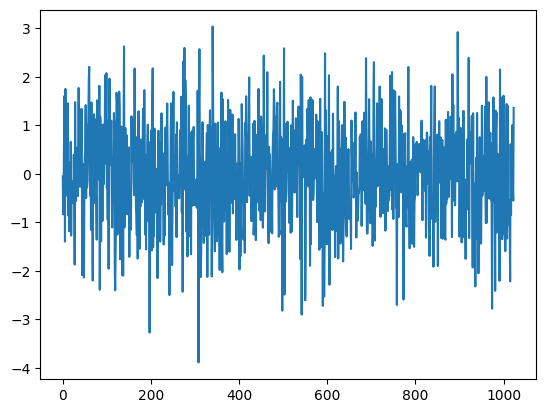

In [29]:
plt.plot(time_series[0])

In [30]:
# Convert to GluonTS arrow format
convert_to_arrow(os.path.join(data_dir, "noise-data.arrow"), time_series=time_series)

### Convert Lorenz trajectories to Arrow file

In [12]:
from dysts.flows import Lorenz

In [13]:
model = Lorenz()
print("defaults: ")
print(vars(model))
print("dt: ", model.dt)
print("period: ", model.period)
print("ic: ", model.ic)
print("params: ", model.params)

defaults: 
{'data_path': '/stor/work/AMDG_Gilpin_Summer2024/miniconda3/envs/chronos/lib/python3.10/site-packages/dysts/data/chaotic_attractors.json', 'name': 'Lorenz', 'params': {'beta': 2.667, 'rho': 28, 'sigma': 10}, 'beta': 2.667, 'rho': 28, 'sigma': 10, 'ic': array([ -9.7869288, -15.03852  ,  20.533978 ]), 'bifurcation_parameter': None, 'citation': 'Lorenz, Edward N (1963). Deterministic nonperiodic flow. Journal of the atmospheric sciences 20.2 (1963): 130-141.', 'correlation_dimension': 1.993931310517824, 'delay': False, 'description': 'A minimal weather model based on atmospheric convection.', 'dt': 0.0003002100350058257, 'embedding_dimension': 3, 'hamiltonian': False, 'initial_conditions': [-9.7869288, -15.03852, 20.533978], 'kaplan_yorke_dimension': 2.075158758095728, 'lyapunov_spectrum_estimated': [1.0910931847726466, 0.02994120961308413, -14.915552395875103], 'maximum_lyapunov_estimated': 0.8917098035724058, 'multiscale_entropy': 1.1541457906835575, 'nonautonomous': False, '

In [14]:
num_ic = 20
training_length = 1024
# training_length = 512
# context_length = 512
forecast_length = 300

pts_per_period = 50

integrator_args = {
    "pts_per_period": pts_per_period,
    "atol": 1e-12,
    "rtol": 1e-12,
}

In [15]:
## Pick num_ic random initial conditions on attractor (randomly select from points from a single trajectory)
ic_traj = model.make_trajectory(1000, pts_per_period=10) #, atol=1e-12, rtol=1e-12)
print(ic_traj.shape)
np.random.seed(0)
sel_inds = np.random.choice(range(1000), size=num_ic, replace=False).astype(int)
print(sel_inds)
ic_vals = ic_traj[sel_inds, :]
print(ic_vals.shape)

# traj_test = list()
# for ic in ic_context_test:
#     model.ic = np.copy(ic)
#     traj = model.make_trajectory(training_length + forecast_length,
#                               timescale="Lyapunov",
#                               method="Radau", **integrator_args)
#     traj_test.append(traj)
# traj_test = np.array(traj_test)

(1000, 3)
[993 859 298 553 672 971  27 231 306 706 496 558 784 239 578  55 906 175
  14  77]
(20, 3)


In [16]:
# dim = model.embedding_dimension
# ics = np.random.standard_normal(size=(num_trajs, dim))

In [17]:
model.gamma = 1

sols = []
sols_x = []
for i in range(num_ic):
    model.ic = ic_vals[i]
    # default settings
    sol = model.make_trajectory(1024, resample=True, pts_per_period=200)
    sols.append(sol)
    sols_x.append(sol[:, 0])

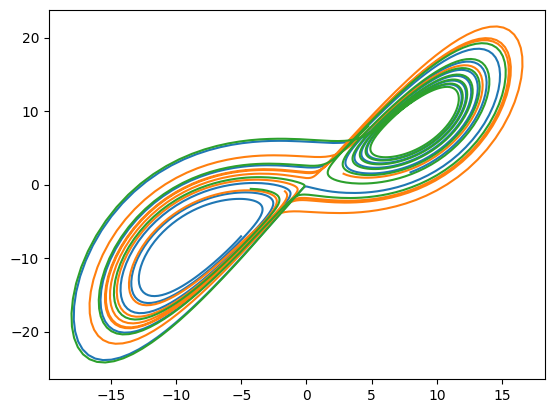

In [31]:
plt.plot(sols[0][:, 0], sols[0][:, 1])
plt.plot(sols[1][:, 0], sols[1][:, 1])
plt.plot(sols[2][:, 0], sols[2][:, 1])

In [32]:
sols[0].shape

(1024, 3)

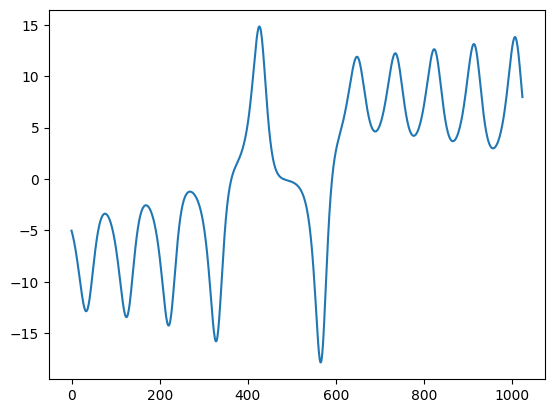

In [33]:
plt.plot(sols[0][:, 0])

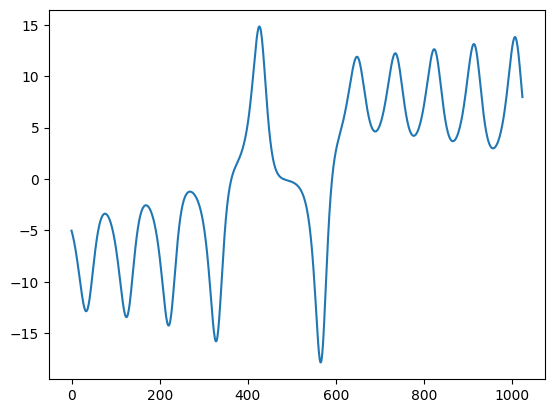

In [34]:
plt.plot(sols_x[0])

In [35]:
# Convert to GluonTS arrow format
# convert_to_arrow("../data/lorenz-data.arrow", time_series=sols_x)
convert_to_arrow(os.path.join(data_dir, "lorenz-data.arrow"), time_series=sols_x)

In [ ]:
# NOTE: this takes a while
from dysts.base import make_trajectory_ensemble
from dysts.utils import standardize_ts

all_out = make_trajectory_ensemble(100, resample=True)
for attractor_name in all_out:
    plt.plot(standardize_ts(all_out[attractor_name])[:, 0], 'k', alpha=0.4)